# Benchmark Analysis

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path
from typing import List, Dict, Any

% matplotlib inline

UsageError: Line magic function `%` not found.


In [3]:
matplotlib.style.use('seaborn-v0_8')  

In [4]:
root_dir = '/Users/diego/Desktop/BENCHMARK_NEBULAC_ALL'

In [5]:
GCC_TBB_COLOR = 'salmon'
NVC_OMP_COLOR = 'green'
NVC_GPU_COLOR = 'beige'


## Utils 

In [6]:
def get_path(*entries):
    return os.path.join(*entries)

In [7]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [8]:
def extraction_pandas_frame_algo(path, COMP="TODO"):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'bytes_per_second', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                 axis=1)

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 3 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 3 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id'], axis=1)
    results_gcc['Compiler'] = COMP
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [9]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '1048576', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [10]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 1048576) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [11]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 1048576) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

# Nebulah all Core

```
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
Address sizes:       43 bits physical, 48 bits virtual
CPU(s):              64
On-line CPU(s) list: 0-63
Thread(s) per core:  1
Core(s) per socket:  32
Socket(s):           2
NUMA node(s):        8
Vendor ID:           AuthenticAMD
CPU family:          23
Model:               1
Model name:          AMD EPYC 7551 32-Core Processor
Stepping:            2
CPU MHz:             2404.199
CPU max MHz:         2000.0000
CPU min MHz:         1200.0000
BogoMIPS:            3992.24
Virtualization:      AMD-V
L1d cache:           32K
L1i cache:           64K
L2 cache:            512K
L3 cache:            8192K
NUMA node0 CPU(s):   0,8,16,24,32,40,48,56
NUMA node1 CPU(s):   2,10,18,26,34,42,50,58
NUMA node2 CPU(s):   4,12,20,28,36,44,52,60
NUMA node3 CPU(s):   6,14,22,30,38,46,54,62
NUMA node4 CPU(s):   1,9,17,25,33,41,49,57
NUMA node5 CPU(s):   3,11,19,27,35,43,51,59
NUMA node6 CPU(s):   5,13,21,29,37,45,53,61
NUMA node7 CPU(s):   7,15,23,31,39,47,55,63
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid extd_apicid amd_dcm aperfmperf pni pclmulqdq monitor ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand lahf_lm cmp_legacy svm extapic cr8_legacy abm sse4a misalignsse 3dnowprefetch osvw skinit wdt tce topoext perfctr_core perfctr_nb bpext perfctr_llc mwaitx cpb hw_pstate sme ssbd sev ibpb vmmcall fsgsbase bmi1 avx2 smep bmi2 rdseed adx smap clflushopt sha_ni xsaveopt xsavec xgetbv1 xsaves clzero irperf xsaveerptr arat npt lbrv svm_lock nrip_save tsc_scale vmcb_clean flushbyasid decodeassists pausefilter pfthreshold avic v_vmsave_vmload vgif overflow_recov succor smca
```

## H1
> Some parallel backends exhibit better performance and scalability when handling nested parallelism for homogeneous
> workloads
>

### Time 

#### Time Comparison - `b1_1_for_each_linear_par`
Check how the runtime without constraining the threads develops with increasing input size

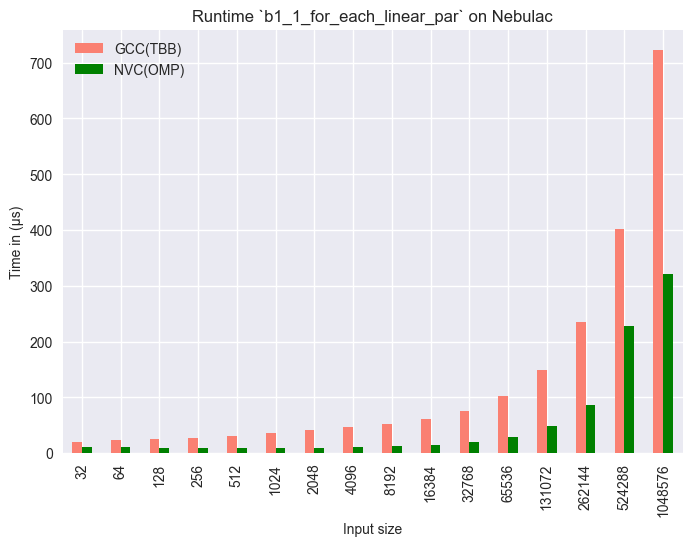

In [12]:
# load data gcc (b1_1_for_each_linear_par)
b1_1_for_each_linear_par_gcc = extraction_pandas_frame_algo(root_dir + '/GCC_TBB/DEFAULT/b1_1_for_each_linear_par__Default.csv',COMP="GCC(TBB)")

b1_1_for_each_linear_par_gcc = b1_1_for_each_linear_par_gcc.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
b1_1_for_each_linear_par_gcc = b1_1_for_each_linear_par_gcc.rename(columns={'real_time':'GCC(TBB)'})

# load data nvhpc (b1_1_for_each_linear_par)
b1_1_for_each_linear_par_nvc_omp = extraction_pandas_frame_algo(root_dir + '/NVHPC_Multicore/DEFAULT/b1_1_for_each_linear_par__Default.csv', COMP="NVC(OMP)")

b1_1_for_each_linear_par_nvc_omp = b1_1_for_each_linear_par_nvc_omp.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
b1_1_for_each_linear_par_nvc_omp = b1_1_for_each_linear_par_nvc_omp.rename(columns={'real_time':'NVC(OMP)'})


# merge for ploting 
b1_1_for_each_linear_par_time_merged = pd.merge(b1_1_for_each_linear_par_gcc, b1_1_for_each_linear_par_nvc_omp, on='n')
b1_1_for_each_linear_par_time_merged

# convert time from ns to microseconds because otherwise it will look really bad
b1_1_for_each_linear_par_time_merged['GCC(TBB)'] = b1_1_for_each_linear_par_time_merged['GCC(TBB)'] / 1_000
b1_1_for_each_linear_par_time_merged['NVC(OMP)'] = b1_1_for_each_linear_par_time_merged['NVC(OMP)'] / 1_000


# plot
b1_1_for_each_linear_par_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

plt.ylabel('Time in (µs)')
plt.xlabel('Input size')
plt.title('Runtime `b1_1_for_each_linear_par` on Nebulac')

plt.show()

#### Time Comparison - `b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par`
Check how the runtime without constraining the threads develops with increasing input size

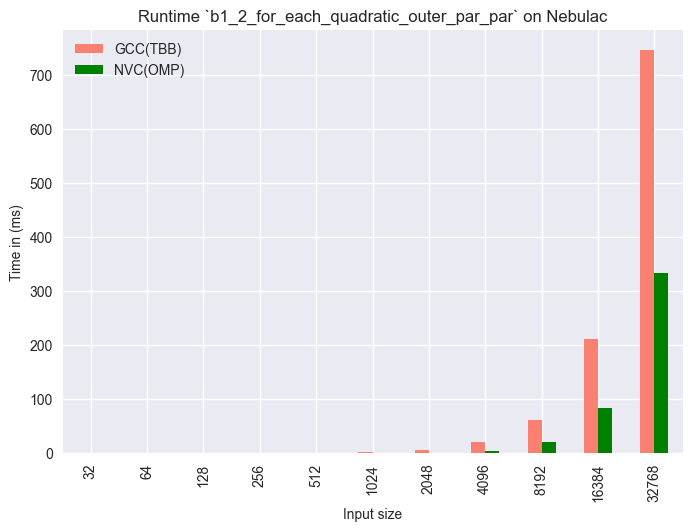

In [13]:
# load data gcc (b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par)
b1_2_for_each_quadratic_par_par_gcc = extraction_pandas_frame_algo(root_dir + '/GCC_TBB/DEFAULT/b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par__Default.csv',COMP="GCC(TBB)")

b1_2_for_each_quadratic_par_par_gcc = b1_2_for_each_quadratic_par_par_gcc.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
b1_2_for_each_quadratic_par_par_gcc = b1_2_for_each_quadratic_par_par_gcc.rename(columns={'real_time':'GCC(TBB)'})


# load data nvhpc (b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par)
b1_2_for_each_quadratic_par_par_nvc_omp = extraction_pandas_frame_algo(root_dir + '/NVHPC_Multicore/DEFAULT/b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par__Default.csv',COMP="NVC(OMP)")

b1_2_for_each_quadratic_par_par_nvc_omp = b1_2_for_each_quadratic_par_par_nvc_omp.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
b1_2_for_each_quadratic_par_par_nvc_omp = b1_2_for_each_quadratic_par_par_nvc_omp.rename(columns={'real_time':'NVC(OMP)'})

# merge for ploting 
b1_2_for_each_quadratic_par_par_time_merged = pd.merge(b1_2_for_each_quadratic_par_par_gcc, b1_2_for_each_quadratic_par_par_nvc_omp, on='n')

# convert time from ns to milliseconds because otherwise it will look really bad
b1_2_for_each_quadratic_par_par_time_merged['GCC(TBB)'] = b1_2_for_each_quadratic_par_par_time_merged['GCC(TBB)'] / 1_000_000
b1_2_for_each_quadratic_par_par_time_merged['NVC(OMP)'] = b1_2_for_each_quadratic_par_par_time_merged['NVC(OMP)'] / 1_000_000

# plot
b1_2_for_each_quadratic_par_par_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

plt.ylabel('Time in (ms)')
plt.xlabel('Input size')
plt.title('Runtime `b1_2_for_each_quadratic_outer_par_par` on Nebulac')

plt.show()

Adding a second graph because small numbers are not readable in the above graph

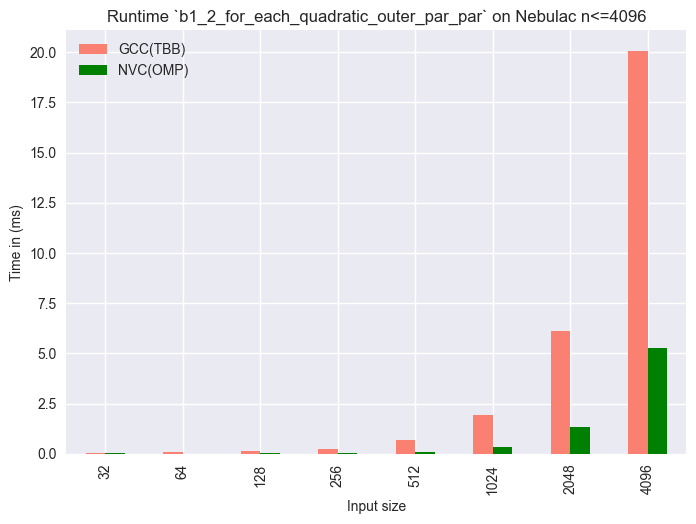

In [14]:
b1_2_for_each_quadratic_par_par_time_merged_sub_4096 = b1_2_for_each_quadratic_par_par_time_merged[b1_2_for_each_quadratic_par_par_time_merged['n'] <= 4096]

# plot
b1_2_for_each_quadratic_par_par_time_merged_sub_4096.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

plt.ylabel('Time in (ms)')
plt.xlabel('Input size')
plt.title('Runtime `b1_2_for_each_quadratic_outer_par_par` on Nebulac n<=4096')

plt.show()

#### Time Comparison - `b1_4_for_each_exponential_par`
Check how the runtime without constraining the threads develops with increasing input size

    GCC(TBB)   n     NVC(OMP)
0   0.018690   4     0.012494
1   0.121331   8     0.042570
2   0.537180  16     1.722970
3  92.126600  32  3170.760000


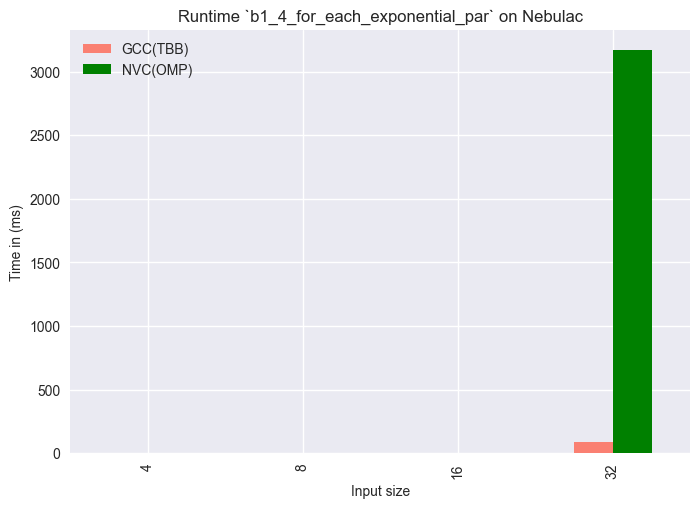

In [15]:
# load data gcc (b1_4_for_each_exponential_par)
b1_4_for_each_exponential_par_gcc = extraction_pandas_frame_algo(root_dir + '/GCC_TBB/DEFAULT/b1_4_for_each_exponential_par__Default.csv',COMP="GCC(TBB)")

b1_4_for_each_exponential_par_gcc = b1_4_for_each_exponential_par_gcc.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
b1_4_for_each_exponential_par_gcc = b1_4_for_each_exponential_par_gcc.rename(columns={'real_time':'GCC(TBB)'})

# load data nvhpc (b1_4_for_each_exponential_par)
b1_4_for_each_exponential_par_nvc_omp = extraction_pandas_frame_algo(root_dir + '/NVHPC_Multicore/DEFAULT/b1_4_for_each_exponential_par__Default.csv',COMP="NVC(OMP)")

b1_4_for_each_exponential_par_nvc_omp = b1_4_for_each_exponential_par_nvc_omp.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
b1_4_for_each_exponential_par_nvc_omp = b1_4_for_each_exponential_par_nvc_omp.rename(columns={'real_time':'NVC(OMP)'})


# merge for ploting 
b1_4_for_each_exponential_par_time_merged = pd.merge(b1_4_for_each_exponential_par_gcc, b1_4_for_each_exponential_par_nvc_omp, on='n')

# convert time from ns to milliseconds because otherwise it will look really bad
b1_4_for_each_exponential_par_time_merged['GCC(TBB)'] = b1_4_for_each_exponential_par_time_merged['GCC(TBB)'] / 1_000_000
b1_4_for_each_exponential_par_time_merged['NVC(OMP)'] = b1_4_for_each_exponential_par_time_merged['NVC(OMP)'] / 1_000_000

print(b1_4_for_each_exponential_par_time_merged)

# plot
b1_4_for_each_exponential_par_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

plt.ylabel('Time in (ms)')
plt.xlabel('Input size')
plt.title('Runtime `b1_4_for_each_exponential_par` on Nebulac')

plt.show()

Adding a second graph because small numbers are not readable in the above graph

   GCC(TBB)   n   NVC(OMP)
0   18.6901   4    12.4941
1  121.3310   8    42.5701
2  537.1800  16  1722.9700


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_68912/1969448607.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b1_4_for_each_exponential_par_time_merged_sub_16['GCC(TBB)'] = b1_4_for_each_exponential_par_time_merged_sub_16['GCC(TBB)'] * 1_000
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_68912/1969448607.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b1_4_for_each_exponential_par_time_merged_sub_16['NVC(OMP)'] = b1_4_for_each_exponential_par_time_merged_sub_16['NVC(OMP)'] 

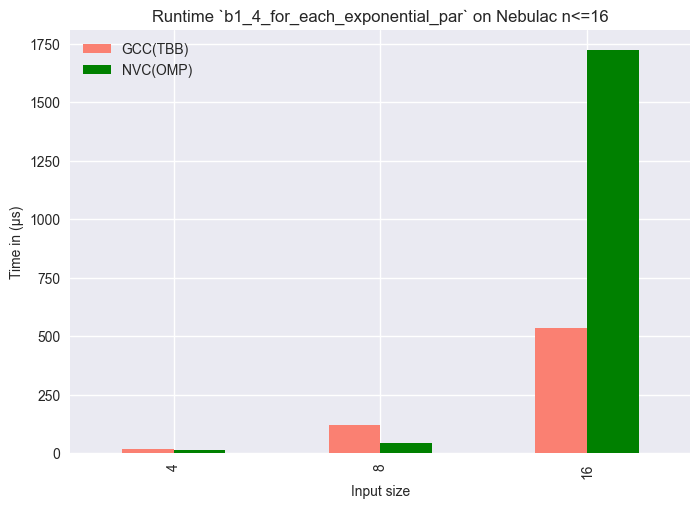

In [16]:
b1_4_for_each_exponential_par_time_merged_sub_16 = b1_4_for_each_exponential_par_time_merged[b1_4_for_each_exponential_par_time_merged['n'] <= 16]

# convert from milliseconds to microseconds 
b1_4_for_each_exponential_par_time_merged_sub_16['GCC(TBB)'] = b1_4_for_each_exponential_par_time_merged_sub_16['GCC(TBB)'] * 1_000
b1_4_for_each_exponential_par_time_merged_sub_16['NVC(OMP)'] = b1_4_for_each_exponential_par_time_merged_sub_16['NVC(OMP)'] * 1_000


# plot
b1_4_for_each_exponential_par_time_merged_sub_16.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

print(b1_4_for_each_exponential_par_time_merged_sub_16)

plt.ylabel('Time in (µs)')
plt.xlabel('Input size')
plt.title('Runtime `b1_4_for_each_exponential_par` on Nebulac n<=16')

plt.show()

### Strong Scaling

`S(p)= T(1) / T(p)`

As based we use once the:
* sequential algorithm 
* parallel algorithm (1 thread)

#### Strong Scaling - `b1_1_for_each_linear` 
1 Million fixed input size with threads 1-64

##### Seq Base

   threads   GCC(TBB)   NVC(OMP)
0        1   0.997915   0.987061
1        2   1.993628   1.971258
2        4   3.966795   3.812405
3        8   7.715379   7.682825
4       16  14.945539  14.531737
5       32  26.258819  25.007096
6       64  42.943653  50.463093


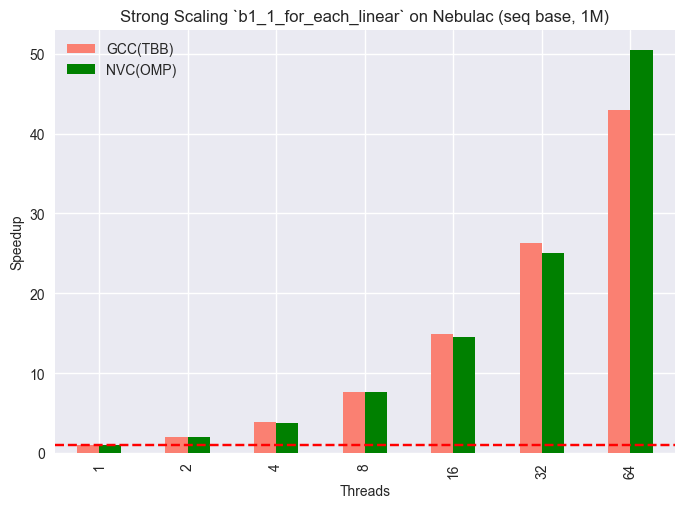

In [17]:
# GCC
## load gcc (b1_1_for_each_linear_seq)
b1_1_for_each_linear_seq_gcc = extraction_pandas_frame_algo(root_dir + '/GCC_TBB/DEFAULT/b1_1_for_each_linear_seq__Default.csv',COMP="GCC(TBB)")

## load gcc threaded b1_1_for_each_linear_par 
b1_1_for_each_linear_threads_gcc = extraction_pandas_frame_algo_threaded(root_dir + '/GCC_TBB/THREADS','b1_1_for_each_linear_par',[1,2,4,8,16,32,64],COMP="GCC(TBB)")

## calculate speedup
b1_1_for_each_linear_strong_scaling_seqbase_gcc = calc_speedup_based_seq(b1_1_for_each_linear_seq_gcc,b1_1_for_each_linear_threads_gcc,"GCC(TBB)")

# NVC(OMP)
## load nvhpc (b1_1_for_each_linear_seq)
b1_1_for_each_linear_seq_nvc_omp = extraction_pandas_frame_algo(root_dir + '/NVHPC_Multicore/DEFAULT/b1_1_for_each_linear_seq__Default.csv',COMP="NVC(OMP)")

## load nvhpc threaded b1_1_for_each_linear_par 
b1_1_for_each_linear_threads_nvc_omp = extraction_pandas_frame_algo_threaded(root_dir + '/NVHPC_Multicore/THREADS','b1_1_for_each_linear_par',[1,2,4,8,16,32,64],COMP="NVC(OMP)")

## calculate speedup
b1_1_for_each_linear_strong_scaling_seqbase_nvc_omp = calc_speedup_based_seq(b1_1_for_each_linear_seq_nvc_omp,b1_1_for_each_linear_threads_nvc_omp,"NVC(OMP)")

# merge for plotting 
b1_1_for_each_linear_seq_speedup_merged = pd.merge(b1_1_for_each_linear_strong_scaling_seqbase_gcc, b1_1_for_each_linear_strong_scaling_seqbase_nvc_omp, on='threads')
print(b1_1_for_each_linear_seq_speedup_merged)

# plot strong scaling
ax = b1_1_for_each_linear_seq_speedup_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')


plt.ylabel('Speedup')
plt.xlabel('Threads')
plt.title('Strong Scaling `b1_1_for_each_linear` on Nebulac (seq base, 1M)')

plt.show()

   threads  GCC(TBB)  NVC(OMP)
0        1  0.997915  0.987061
1        2  0.996814  0.985629
2        4  0.991699  0.953101
3        8  0.964422  0.960353
4       16  0.934096  0.908234
5       32  0.820588  0.781472
6       64  0.670995  0.788486


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_68912/3790263233.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


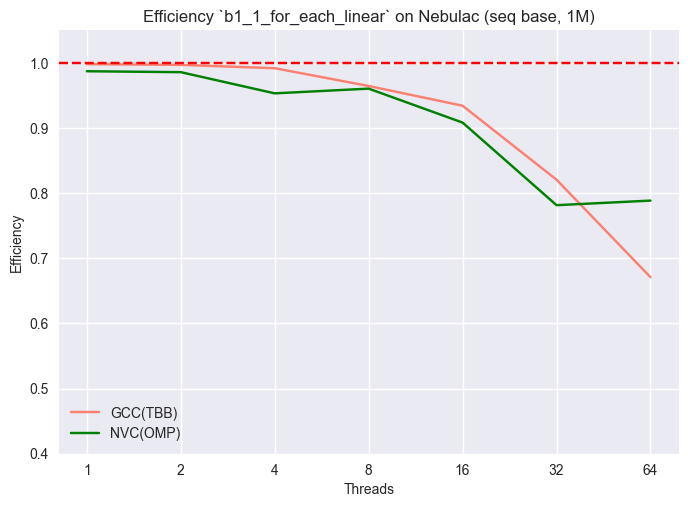

In [18]:
## efficiency graph
b1_1_for_each_linear_seq_efficiency = b1_1_for_each_linear_seq_speedup_merged.copy()
b1_1_for_each_linear_seq_efficiency['GCC(TBB)'] = b1_1_for_each_linear_seq_efficiency['GCC(TBB)'] / b1_1_for_each_linear_seq_efficiency['threads']
b1_1_for_each_linear_seq_efficiency['NVC(OMP)'] = b1_1_for_each_linear_seq_efficiency['NVC(OMP)'] / b1_1_for_each_linear_seq_efficiency['threads']

print(b1_1_for_each_linear_seq_efficiency)

# plot efficiency
ax = b1_1_for_each_linear_seq_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylim(0.4,1.05)

plt.xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.ylabel('Efficiency')
plt.xlabel('Threads')
plt.title('Efficiency `b1_1_for_each_linear` on Nebulac (seq base, 1M)')

plt.show()

##### Par(1) Base

   threads   GCC(TBB)   NVC(OMP)
0        1   1.000000   1.000000
1        2   1.997794   1.997099
2        4   3.975084   3.862382
3        8   7.731503   7.783538
4       16  14.976772  14.722232
5       32  26.313694  25.334912
6       64  43.033396  51.124609


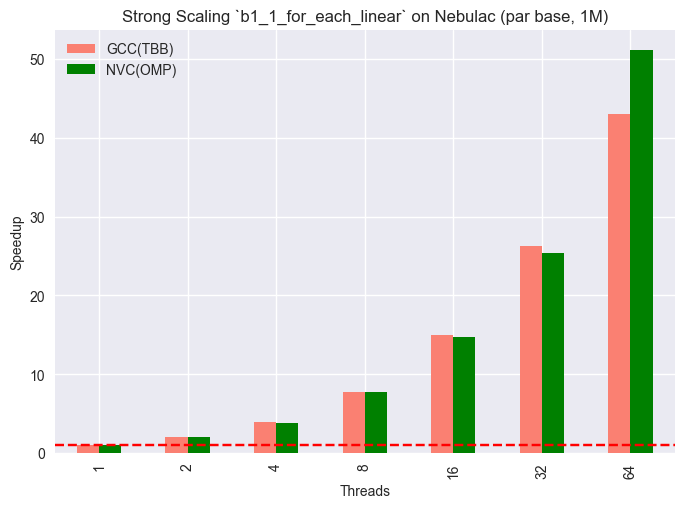

In [19]:
# GCC(TBB)
## load gcc threaded b1_1_for_each_linear_par 
b1_1_for_each_linear_threads_gcc = extraction_pandas_frame_algo_threaded(root_dir + '/GCC_TBB/THREADS','b1_1_for_each_linear_par',[1,2,4,8,16,32,64],COMP="GCC(TBB)")

## calc strong scaling 
b1_1_for_each_linear_strong_scaling_parbase_gcc = calc_speedup_based_par(b1_1_for_each_linear_threads_gcc,"GCC(TBB)")

# NVC(OMP)
## load nvhpc threaded b1_1_for_each_linear_par 
b1_1_for_each_linear_threads_nvc_omp = extraction_pandas_frame_algo_threaded(root_dir + '/NVHPC_Multicore/THREADS','b1_1_for_each_linear_par',[1,2,4,8,16,32,64],COMP="NVC(OMP)")

## calc strong scaling
b1_1_for_each_linear_strong_scaling_parbase_nvc_omp = calc_speedup_based_par(b1_1_for_each_linear_threads_nvc_omp,"NVC(OMP)")


# merge for plotting 
b1_1_for_each_linear_seq_parbase_speedup_merged = pd.merge(b1_1_for_each_linear_strong_scaling_parbase_gcc, b1_1_for_each_linear_strong_scaling_parbase_nvc_omp, on='threads')
print(b1_1_for_each_linear_seq_parbase_speedup_merged)

# plot strong scaling
ax = b1_1_for_each_linear_seq_parbase_speedup_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')


plt.ylabel('Speedup')
plt.xlabel('Threads')
plt.title('Strong Scaling `b1_1_for_each_linear` on Nebulac (par base, 1M)')

plt.show()

   threads  GCC(TBB)  NVC(OMP)
0        1  1.000000  1.000000
1        2  0.998897  0.998549
2        4  0.993771  0.965595
3        8  0.966438  0.972942
4       16  0.936048  0.920140
5       32  0.822303  0.791716
6       64  0.672397  0.798822


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_68912/3088997708.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


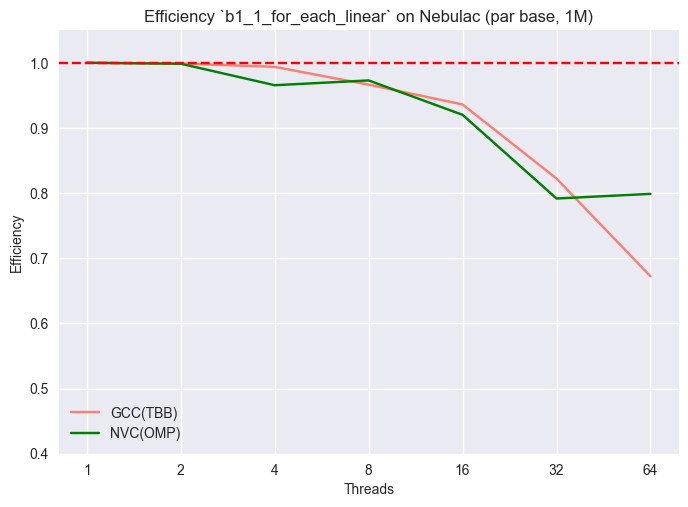

In [20]:
## efficiency graph
b1_1_for_each_linear_seq_efficiency = b1_1_for_each_linear_seq_parbase_speedup_merged.copy()
b1_1_for_each_linear_seq_efficiency['GCC(TBB)'] = b1_1_for_each_linear_seq_efficiency['GCC(TBB)'] / b1_1_for_each_linear_seq_efficiency['threads']
b1_1_for_each_linear_seq_efficiency['NVC(OMP)'] = b1_1_for_each_linear_seq_efficiency['NVC(OMP)'] / b1_1_for_each_linear_seq_efficiency['threads']

print(b1_1_for_each_linear_seq_efficiency)

# plot efficiency
ax = b1_1_for_each_linear_seq_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylim(0.4,1.05)

plt.xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.ylabel('Efficiency')
plt.xlabel('Threads')
plt.title('Efficiency `b1_1_for_each_linear` on Nebulac (par base, 1M)')

plt.show()

#### Strong Scaling - `b1_2_for_each_quadratic` 
1 Million fixed input size with threads 1-64

##### Seq Base

Here we wont do it with seq base because its not really realistic

##### Par(1) Base

   threads   GCC(TBB)   NVC(OMP)
0        1   1.000000   1.000000
1        2   2.012084   1.989333
2        4   4.028875   3.965606
3        8   8.029452   7.085557
4       16  15.840287  15.510771
5       32  27.573592  23.361771
6       64  49.508283  32.807058


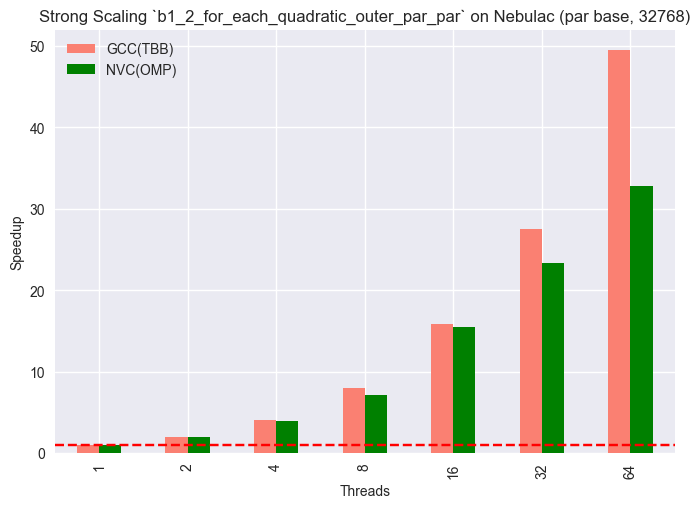

In [21]:
# GCC(TBB)
## load gcc threaded b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par 
b1_2_for_each_quadratic_par_par_threads_gcc = extraction_pandas_frame_algo_threaded(root_dir + '/GCC_TBB/THREADS','b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par',[1,2,4,8,16,32,64],COMP="GCC(TBB)",input_size=32768)

## calc strong scaling
b1_2_for_each_quadratic_par_par_scaling_parbase_gcc = calc_speedup_based_par(b1_2_for_each_quadratic_par_par_threads_gcc,"GCC(TBB)")

# NVC(OMP)
## load nvhpc threaded b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par 
b1_2_for_each_quadratic_par_par_threads_nvc_omp = extraction_pandas_frame_algo_threaded(root_dir + '/NVHPC_Multicore/THREADS','b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par',[1,2,4,8,16,32,64],COMP="NVC(OMP)",input_size=32768)

## calc strong scaling 
b1_2_for_each_quadratic_par_par_scaling_parbase_nvc_omp = calc_speedup_based_par(b1_2_for_each_quadratic_par_par_threads_nvc_omp,"NVC(OMP)")

# merge for plotting
b1_2_for_each_quadratic_par_par_speedup_merged = pd.merge(b1_2_for_each_quadratic_par_par_scaling_parbase_gcc, b1_2_for_each_quadratic_par_par_scaling_parbase_nvc_omp, on='threads')
print(b1_2_for_each_quadratic_par_par_speedup_merged)

# plot strong scaling
ax = b1_2_for_each_quadratic_par_par_speedup_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')


plt.ylabel('Speedup')
plt.xlabel('Threads')
plt.title('Strong Scaling `b1_2_for_each_quadratic_outer_par_par` on Nebulac (par base, 32768)')

plt.show()

   threads  GCC(TBB)  NVC(OMP)
0        1  1.000000  1.000000
1        2  1.006042  0.994667
2        4  1.007219  0.991402
3        8  1.003681  0.885695
4       16  0.990018  0.969423
5       32  0.861675  0.730055
6       64  0.773567  0.512610


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_68912/3967602652.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


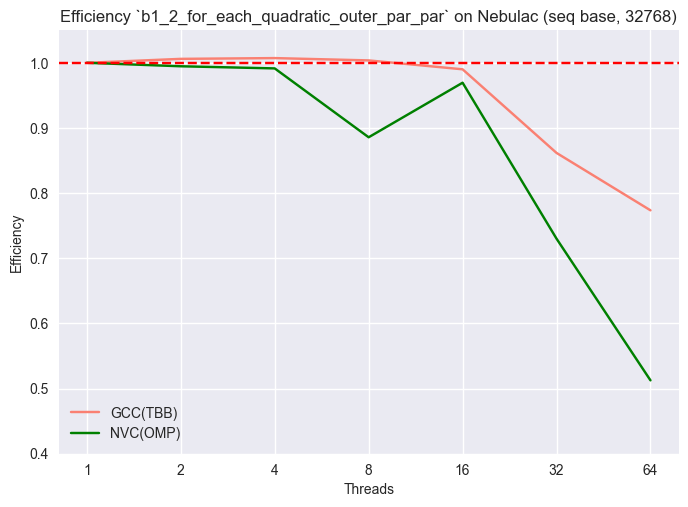

In [22]:
## efficiency graph
b1_2_for_each_quadratic_par_par_efficiency = b1_2_for_each_quadratic_par_par_speedup_merged.copy()
b1_2_for_each_quadratic_par_par_efficiency['GCC(TBB)'] = b1_2_for_each_quadratic_par_par_efficiency['GCC(TBB)'] / b1_2_for_each_quadratic_par_par_efficiency['threads']
b1_2_for_each_quadratic_par_par_efficiency['NVC(OMP)'] = b1_2_for_each_quadratic_par_par_efficiency['NVC(OMP)'] / b1_2_for_each_quadratic_par_par_efficiency['threads']

print(b1_2_for_each_quadratic_par_par_efficiency)

# plot efficiency
ax = b1_2_for_each_quadratic_par_par_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylim(0.4,1.05)

plt.xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.ylabel('Efficiency')
plt.xlabel('Threads')
plt.title('Efficiency `b1_2_for_each_quadratic_outer_par_par` on Nebulac (par base, 32768)')

plt.show()

#### Strong Scaling - `b1_4_for_each_exponential` 
32 fixed input size with threads 1-64

##### Seq Base

   threads  GCC(TBB)  NVC(OMP)
0        1  0.220355  0.210447
1        2  0.362259  0.195431
2        4  0.566315  0.223379
3        8  1.145408  0.173250
4       16  2.241314  0.190904
5       32  3.970097  0.171405
6       64  6.585767  0.217449


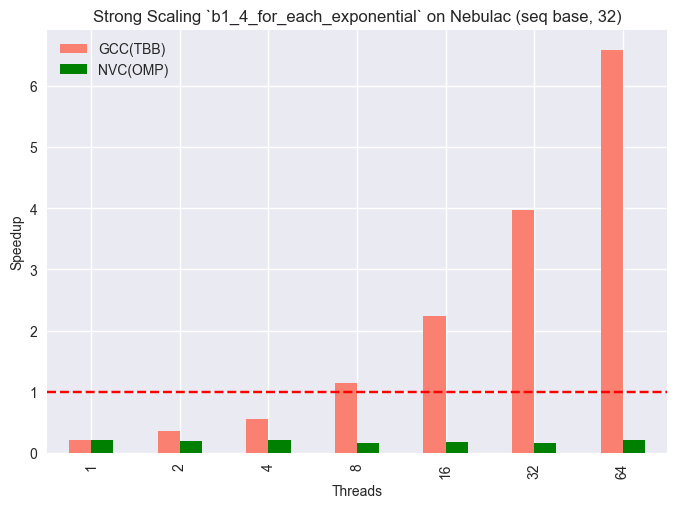

In [23]:
# GCC
## load gcc (b1_4_for_each_exponential_seq)
b1_4_for_each_exponential_seq_gcc = extraction_pandas_frame_algo(root_dir + '/GCC_TBB/DEFAULT/b1_4_for_each_exponential_seq__Default.csv',COMP="GCC(TBB)")

## load gcc threaded b1_4_for_each_exponential_par 
b1_4_for_each_exponential_threads_gcc = extraction_pandas_frame_algo_threaded(root_dir + '/GCC_TBB/THREADS','b1_4_for_each_exponential_par',[1,2,4,8,16,32,64],COMP="GCC(TBB)",input_size=32)

## calculate speedup
b1_4_for_each_exponential_strong_scaling_seqbase_gcc = calc_speedup_based_seq(b1_4_for_each_exponential_seq_gcc,b1_4_for_each_exponential_threads_gcc,"GCC(TBB)",input_size=32)

# NVC(OMP)
## load nvhpc (b1_4_for_each_exponential_seq)
b1_4_for_each_exponential_seq_nvc_omp = extraction_pandas_frame_algo(root_dir + '/NVHPC_Multicore/DEFAULT/b1_4_for_each_exponential_seq__Default.csv',COMP="NVC(OMP)")

## load nvhpc threaded b1_4_for_each_exponential_par
b1_4_for_each_exponential_threads_nvc_omp = extraction_pandas_frame_algo_threaded(root_dir + '/NVHPC_Multicore/THREADS','b1_4_for_each_exponential_par',[1,2,4,8,16,32,64],COMP="NVC(OMP)",input_size=32) 

## calculate speedup
b1_4_for_each_exponential_strong_scaling_seqbase_nvc_omp = calc_speedup_based_seq(b1_4_for_each_exponential_seq_nvc_omp,b1_4_for_each_exponential_threads_nvc_omp,"NVC(OMP)",input_size=32)


# merge for plotting 
b1_4_for_each_exponential_seq_speedup_merged = pd.merge(b1_4_for_each_exponential_strong_scaling_seqbase_gcc, b1_4_for_each_exponential_strong_scaling_seqbase_nvc_omp, on='threads')
print(b1_4_for_each_exponential_seq_speedup_merged)

# plot strong scaling
ax = b1_4_for_each_exponential_seq_speedup_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')


plt.ylabel('Speedup')
plt.xlabel('Threads')
plt.title('Strong Scaling `b1_4_for_each_exponential` on Nebulac (seq base, 32)')

plt.show()


   threads  GCC(TBB)  NVC(OMP)
0        1  0.220355  0.210447
1        2  0.181129  0.097715
2        4  0.141579  0.055845
3        8  0.143176  0.021656
4       16  0.140082  0.011931
5       32  0.124066  0.005356
6       64  0.102903  0.003398


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_68912/4127874945.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


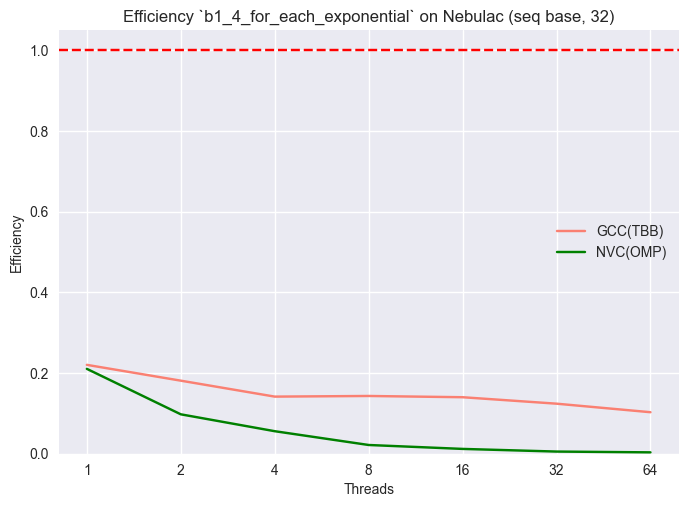

In [24]:
## efficiency graph
b1_4_for_each_exponential_seq_efficiency = b1_4_for_each_exponential_seq_speedup_merged.copy()
b1_4_for_each_exponential_seq_efficiency['GCC(TBB)'] = b1_4_for_each_exponential_seq_efficiency['GCC(TBB)'] / b1_4_for_each_exponential_seq_efficiency['threads']
b1_4_for_each_exponential_seq_efficiency['NVC(OMP)'] = b1_4_for_each_exponential_seq_efficiency['NVC(OMP)'] / b1_4_for_each_exponential_seq_efficiency['threads']

print(b1_4_for_each_exponential_seq_efficiency)

# plot efficiency
ax = b1_4_for_each_exponential_seq_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylim(0,1.05)

plt.xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.ylabel('Efficiency')
plt.xlabel('Threads')
plt.title('Efficiency `b1_4_for_each_exponential` on Nebulac (seq base, 32)')

plt.show()

##### Par(1) Base

   threads   GCC(TBB)  NVC(OMP)
0        1   1.000000  1.000000
1        2   1.643982  0.928644
2        4   2.570017  1.061446
3        8   5.198022  0.823248
4       16  10.171399  0.907134
5       32  18.016857  0.814478
6       64  29.887137  1.033271


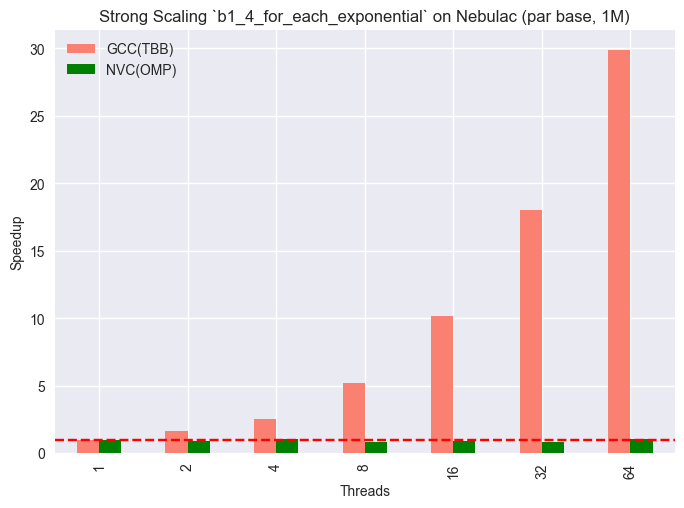

In [25]:
# GCC
## load gcc threaded b1_4_for_each_exponential_par 
b1_4_for_each_exponential_threads_gcc = extraction_pandas_frame_algo_threaded(root_dir + '/GCC_TBB/THREADS','b1_4_for_each_exponential_par',[1,2,4,8,16,32,64],COMP="GCC(TBB)",input_size=32)

## calc strong scaling 
b1_4_for_each_exponential_strong_scaling_parbase_gcc = calc_speedup_based_par(b1_4_for_each_exponential_threads_gcc,"GCC(TBB)")


# NVC(OMP)
## load nvhpc threaded b1_4_for_each_exponential_par
b1_4_for_each_exponential_threads_nvc_omp = extraction_pandas_frame_algo_threaded(root_dir + '/NVHPC_Multicore/THREADS','b1_4_for_each_exponential_par',[1,2,4,8,16,32,64],COMP="NVC(OMP)",input_size=32) 

## calc strong scaling 
b1_4_for_each_exponential_strong_scaling_parbase_nvc_omp = calc_speedup_based_par(b1_4_for_each_exponential_threads_nvc_omp,"NVC(OMP)")


# merge for plotting 
b1_4_for_each_linear_seq_parbase_speedup_merged = pd.merge(b1_4_for_each_exponential_strong_scaling_parbase_gcc, b1_4_for_each_exponential_strong_scaling_parbase_nvc_omp, on='threads')
print(b1_4_for_each_linear_seq_parbase_speedup_merged)

# plot strong scaling
ax = b1_4_for_each_linear_seq_parbase_speedup_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')


plt.ylabel('Speedup')
plt.xlabel('Threads')
plt.title('Strong Scaling `b1_4_for_each_exponential` on Nebulac (par base, 1M)')

plt.show()

   threads  GCC(TBB)  NVC(OMP)
0        1  1.000000  1.000000
1        2  0.821991  0.464322
2        4  0.642504  0.265362
3        8  0.649753  0.102906
4       16  0.635712  0.056696
5       32  0.563027  0.025452
6       64  0.466987  0.016145


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_68912/2443303117.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


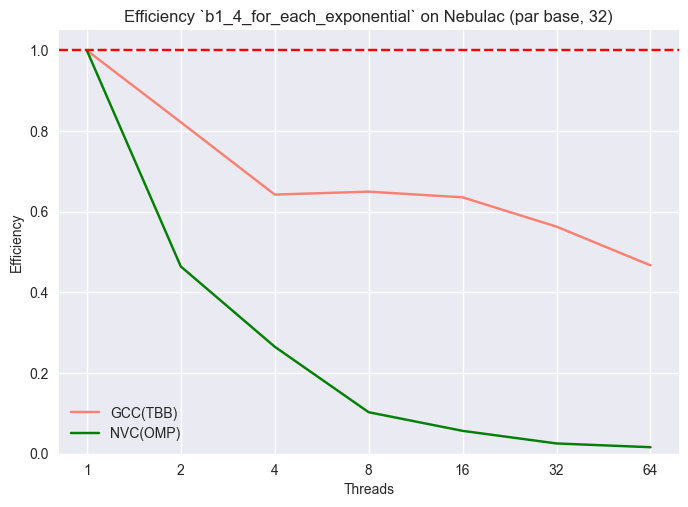

In [26]:
## efficiency graph
b1_4_for_each_linear_seq_parbase_efficiency = b1_4_for_each_linear_seq_parbase_speedup_merged.copy()
b1_4_for_each_linear_seq_parbase_efficiency['GCC(TBB)'] = b1_4_for_each_linear_seq_parbase_efficiency['GCC(TBB)'] / b1_4_for_each_linear_seq_parbase_efficiency['threads']
b1_4_for_each_linear_seq_parbase_efficiency['NVC(OMP)'] = b1_4_for_each_linear_seq_parbase_efficiency['NVC(OMP)'] / b1_4_for_each_linear_seq_parbase_efficiency['threads']

print(b1_4_for_each_linear_seq_parbase_efficiency)

# plot efficiency
ax = b1_4_for_each_linear_seq_parbase_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylim(0,1.05)

plt.xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.ylabel('Efficiency')
plt.xlabel('Threads')
plt.title('Efficiency `b1_4_for_each_exponential` on Nebulac (par base, 32)')

plt.show()

### Performance Portability Calculation (Inter Compiler)

for this group we can "calculate" a performance probability by looking at the strong scaling speedup every compiler has when using the max amount of cores. (aka running with 1M entries at max core) (insipred by [1])

example:

```
|          | achieved | perfect | efficiency  | 
|----------|----------|---------|-------------|
| GCC(TBB) | 12       | 16      | 12/16=0.75  |
| NVC(OMP) | 16       | 16      | 16/16=1     |
| NVC(GPU) | 0        | 0       | 0           |
| Intel    | 14       | 16      | 14/16=0.875 |

Performance Portability for `{GCC(TBB), NVC(OMP), NVC(GPU), Intel}` = 0

Performance Portability for `{GCC(TBB), NVC(OMP), Intel}` = `3/((1/0,75)+ (1/1) + (1/0,875))` = 86.3%

```

In [27]:
max_cores :int = 64


b1_1_data = []
b1_2_data = []
b1_4_data = []

print("GCC")
# calculate efficiency for gcc on max core for `b1_1_for_each_linear`
b1_1_for_each_linear_speed_up_64_gcc = b1_1_for_each_linear_strong_scaling_parbase_gcc[b1_1_for_each_linear_strong_scaling_parbase_gcc['threads'] == 64].iloc[0]['GCC(TBB)']
b1_1_data.append(b1_1_for_each_linear_speed_up_64_gcc)

print("\tb1_1 Speedup(64):", b1_1_for_each_linear_speed_up_64_gcc)


# calculate efficiency for gcc on max core for `b1_2_for_each_quadratic`
b1_2_for_each_quadratic_par_par_speed_up_64_gcc = b1_2_for_each_quadratic_par_par_scaling_parbase_gcc[b1_2_for_each_quadratic_par_par_scaling_parbase_gcc['threads'] == 64].iloc[0]['GCC(TBB)']
b1_2_data.append(b1_2_for_each_quadratic_par_par_speed_up_64_gcc)

print("\tb1_2 Speedup(64):", b1_2_for_each_quadratic_par_par_speed_up_64_gcc)



# calculate efficiency for gcc on max core for `b1_4_for_each_exponential`
b1_4_for_each_exponential_speed_up_64_gcc = b1_4_for_each_exponential_strong_scaling_parbase_gcc[b1_4_for_each_exponential_strong_scaling_parbase_gcc['threads'] == 64].iloc[0]['GCC(TBB)']
b1_4_data.append(b1_4_for_each_exponential_speed_up_64_gcc)

print("\tb1_4 Speedup(64):", b1_4_for_each_exponential_speed_up_64_gcc)


print("\nNVC(OMP)")
# calculate efficiency for nvhpc(mc) on max core for `b1_1_for_each_linear`
b1_1_for_each_linear_speed_up_64_nvc_omp = b1_1_for_each_linear_strong_scaling_parbase_nvc_omp[b1_1_for_each_linear_strong_scaling_parbase_nvc_omp['threads'] == 64].iloc[0]['NVC(OMP)']
b1_1_data.append(b1_1_for_each_linear_speed_up_64_nvc_omp)

print("\tb1_1 Speedup(64):", b1_1_for_each_linear_speed_up_64_nvc_omp)

# calculate efficiency for nvhpc(mc) on max core for `b1_2_for_each_quadratic`
b1_2_for_each_quadratic_par_par_speed_up_64_nvc_omp = b1_2_for_each_quadratic_par_par_scaling_parbase_nvc_omp[b1_2_for_each_quadratic_par_par_scaling_parbase_nvc_omp['threads'] == 64].iloc[0]['NVC(OMP)']
b1_2_data.append(b1_2_for_each_quadratic_par_par_speed_up_64_nvc_omp)

print("\tb1_2 Speedup(64):", b1_2_for_each_quadratic_par_par_speed_up_64_nvc_omp)

# calculate efficiency for nvhpc(mc) on max core for `b1_4_for_each_exponential`
b1_4_for_each_exponential_speed_up_64_nvc_omp = b1_4_for_each_exponential_strong_scaling_parbase_nvc_omp[b1_4_for_each_exponential_strong_scaling_parbase_nvc_omp['threads'] == 64].iloc[0]['NVC(OMP)']
b1_4_data.append(b1_4_for_each_exponential_speed_up_64_nvc_omp)
print("\tb1_4 Speedup(64):", b1_4_for_each_exponential_speed_up_64_nvc_omp)

print("\n\n")

# calc
b1_1_perfect = max(b1_1_data)
b1_2_perfect = max(b1_2_data)
b1_4_perfect = max(b1_4_data)


# Performance portability b1_1 inter compiler
b1_1_efficiency = [x / b1_1_perfect for x in b1_1_data]
pp_b1_1 = len(b1_1_efficiency) / (sum([1 / x for x in b1_1_efficiency]))

print("Performance Portability B1_1: " , pp_b1_1)


# Performance portability b1_2 inter compiler
b1_2_efficiency = [x / b1_2_perfect for x in b1_2_data]
pp_b1_2 = len(b1_2_efficiency) / (sum([1 / x for x in b1_2_efficiency]))

print("Performance Portability B1_1: " , pp_b1_2)


# Performance portability b1_4 inter compiler
b1_4_efficiency = [x / b1_4_perfect for x in b1_4_data]
pp_b1_4 = len(b1_4_efficiency) / (sum([1 / x for x in b1_4_efficiency]))

print("Performance Portability B1_4: " , pp_b1_4)



GCC
	b1_1 Speedup(64): 43.03339575922877
	b1_2 Speedup(64): 49.50828342574879
	b1_4 Speedup(64): 29.887136604756876

NVC(OMP)
	b1_1 Speedup(64): 51.12460858208368
	b1_2 Speedup(64): 32.80705823482036
	b1_4 Speedup(64): 1.0332712232351373



Performance Portability B1_1:  0.914067711189745
Performance Portability B1_1:  0.7971067743386567
Performance Portability B1_4:  0.0668342558082125


### Findings for H1

#### `b1_1`
There is a significant runtime difference between parallel backends (TBB and NVC(OMP) ) when we are dealing with quite rudimentary linear homogenous workloads. As you can see in [figure of runtime comparisons](#time-comparison---b1_1_for_each_linear_par). The larger the input size gets the worse the performance of GCC(with TBB) gets. On the other side NVC(with OMP backend) seems to scale quite good under linear homogenous workloads.

For strong scaling we can see that calculating the speedup using the parallel implementation with 1 thread and using the sequential implementation, does not make a huge difference. In fact the overhead for this kind of workload seems to be minimal.
The backends scale fairly good and the absolute speedup for each number of threads does not have a tremendous difference between the two backends. We only start to notice that the more threads we utilize the larger the speedup between GCC(TBB) and NVC(OMP) gets. 

For small number of threads (1-16) we see that the speedup is quite optimal (close to perfect speedup). Only later when utilizing more threads (32+) we start to see a significant performance loss for both GCC(TBB) and NVC(OMP)


Since the performance portability metric used in this hypothesis focuses on the speedup and as observed above, the difference between speedup is not that huge, we achieve a rather high performance portability of **91%**!

Key observation:
* Significant runtime differences between GCC(TBB) and NVC(OMP)
* Speedup seems to be on same level for backends only for huge number of threads it starts to degrade
* Small number of threads nearly perfect speedup for both
* Performance portability quite high since backends behave quite good.